# **Pre-Screen Applications Project** (SOLUTIONS & OUTPUTS)

Source:  [https://github.com/d-insight/code-bank.git](https://github.com/d-insight/code-bank.git)  
License: [MIT License](https://opensource.org/licenses/MIT). See open source [license](LICENSE) in the Code Bank repository. 

-------------

## Overview

Founded in 2000 by a high school teacher in the Bronx, DonorsChoose.org empowers public school teachers from across the country to request much-needed materials and experiences for their students. At any given time, there are thousands of classroom requests that can be brought to life with a gift of any amount.

DonorsChoose.org receives hundreds of thousands of project proposals each year for classroom projects in need of funding. Right now, a large number of volunteers is needed to manually screen each submission before it's approved to be posted on the DonorsChoose.org website.

In this project, we will predict the probability that a DonorsChoose.org project proposal submitted by a teacher will be approved, using the text of project descriptions as well as additional metadata about the project, teacher, and school. DonorsChoose.org can then use this information to identify projects most likely to need further review before approval. Hence, the organisation can save the time of volunteer reviewers so that they can focus on more promising projects.

Your machine learning algorithm can help more teachers get funded more quickly, and with less cost to DonorsChoose.org, allowing them to channel even more funding directly to classrooms across the country.

<img src="https://cached.imagescaler.hbpl.co.uk/resize/scaleWidth/580/cached.offlinehbpl.hbpl.co.uk/news/NST/C8B9CC1D-03B0-9B80-4CFE78B5B539240F.jpg" width="500" height="500" align="center"/>

Image source: https://cached.imagescaler.hbpl.co.uk/resize/scaleWidth/580/cached.offlinehbpl.hbpl.co.uk/news/NST/C8B9CC1D-03B0-9B80-4CFE78B5B539240F.jpg

As you will see, this dataset includes many different kinds of features with structured and unstructured data. You need to predict whether an application needs further study. To assess the quality of your predictions, consider the area under the curve (AUC) performance metric.

The dataset consists of application materials (see *application_data.csv*) and resources requested (see *resource_data.csv*).

The application materials data (see *application_data.csv*) contains the following features.

| Feature name  | Description  |
|----------------|--------------|
| id  | Unique id of the project application    |
| teacher_id    | id of the teacher submitting the application  |
| teacher_prefix    | title of the teacher's name (Ms., Mr., etc.)    |
| school_state    | US state of the teacher's school    |
| project_submitted_datetime    | application submission timestamp    |
| project_grade_category    | school grade levels (PreK-2, 3-5, 6-8, and 9-12)   |
| project_subject_categories   | category of the project (e.g., "Music & The Arts")    |
| project_subject_subcategories    | sub-category of the project (e.g., "Visual Arts")    |
| project_title    | title of the project    |
| project_essay_1    | first essay*   |
| project_essay_2    | second essay*    |
| project_essay_3    | third essay*   |
| project_essay_4    | fourth essay*  |
| project_resource_summary    | summary of the resources needed for the project    |
| teacher_number_of_previously_posted_projects   | number of previously posted applications by the submitting teacher    |
| project_is_approved    | whether DonorsChoose proposal was accepted (0="rejected", 1="accepted"); train.csv only    |


\*Note: Prior to May 17, 2016, the prompts for the essays were as follows:

  * project_essay_1: "Introduce us to your classroom"  

  * project_essay_2: "Tell us more about your students"  

  * project_essay_3: "Describe how your students will use the materials you're requesting"  

  * project_essay_4: "Close by sharing why your project will make a difference"  

Starting on May 17, 2016, the number of essays was reduced from 4 to 2, and the prompts for the first 2 essays were changed to the following:

  * project_essay_1: "Describe your students: What makes your students special? Specific details about their background, your neighborhood, and your school are all helpful."  

  * project_essay_2: "About your project: How will these materials make a difference in your students' learning and improve their school lives?"  

For all projects with project_submitted_datetime of 2016-05-17 and later, the values of project_essay_3 and project_essay_4 will be missing (i.e. NaN).


Proposals also include resources requested. Each project may include multiple requested resources (see *resource_data.csv*). Each row in *resource_data.csv* corresponds to a resource, so multiple rows may tie to the same project by id.

The resource data contains the following features.

| Feature name  | Description  |
|----------------|--------------|
| id  | unique id of the project application; joins with test.csv. and train.csv on id   |
| description    |  description of the resource requested     |
| quantity   | quantity of resource requested      |
| price    | price of resource requested      |


Dataset source: [Kaggle DonorsChoose.org Application Screening challenge](https://www.kaggle.com/c/donorschoose-application-screening/data)

The problem is divided into several parts. For each part, you will have time to work on the question yourself. Feel free to go back to the Demo, use Google/Stackoverflow and work with your neighbour. Together, we will review and discuss the solution to each part.

-------------

## **Part 0**: Setup

In [1]:
# Import all packages 
import re
import nltk
nltk.download('stopwords')

# Use short-hand for standard packages
import pandas            as pd
import numpy             as np
import matplotlib.pyplot as plt
import texthero          as hero

# Import individual functions
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.decomposition           import PCA
from sklearn.model_selection         import StratifiedKFold, GridSearchCV, cross_val_score
from sklearn.pipeline                import Pipeline
from scipy.sparse                    import hstack
from bs4                             import BeautifulSoup
from nltk.corpus                     import stopwords 
from nltk.stem                       import SnowballStemmer
from xgboost                         import XGBClassifier
from collections                     import Counter

# Special code to ignore un-important warnings 
import warnings
warnings.filterwarnings('ignore')

# Ensure that output of plotting commands is displayed inline
%matplotlib inline

# Set the maximum number of rows displayed 
pd.options.display.max_rows = 1000

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/maximilianhofer/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
# Define all constants

SEED    = 41  # base to generate a random number
SCORE   = 'roc_auc'
FIGSIZE = (16, 10)

## **Part 1**: Data Preprocessing and EDA

First, we have to download the data. Next, we would like to understand the main characteristics of the dataset. We might need to transform and clean some features before we can specify a statistical model.

**Q 1:** Unlike other projects, this project includes a training set too big for GitHub. Through the terminal lab of Jupyter lab, download the data using the *wget* command, unzip it using the *zip* command and check that it's in the root directory of the project. 

Locations : 

    Applications dataset: https://storage.googleapis.com/dsfm-datasets/text-applications/application_data.csv.zip
    Resources dataset: https://storage.googleapis.com/dsfm-datasets/text-applications/resource_data.csv.zip

Hint: Use *wget* and *unzip* commands. Use *!* followed by a bash command in a cell to run a bash command.

In [3]:
!wget -N 'https://storage.googleapis.com/dsfm-datasets/text-applications/application_data.csv.zip'
!wget -N 'https://storage.googleapis.com/dsfm-datasets/text-applications/resource_data.csv.zip'
!unzip -o application_data.csv.zip
!unzip -o resource_data.csv.zip

--2021-04-29 17:24:33--  https://storage.googleapis.com/dsfm-datasets/text-applications/application_data.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.168.16, 172.217.168.48, 172.217.168.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.168.16|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘application_data.csv.zip’ not modified on server. Omitting download.

--2021-04-29 17:24:34--  https://storage.googleapis.com/dsfm-datasets/text-applications/resource_data.csv.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 172.217.168.16, 172.217.168.48, 172.217.168.80, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|172.217.168.16|:443... connected.
HTTP request sent, awaiting response... 304 Not Modified
File ‘resource_data.csv.zip’ not modified on server. Omitting download.

Archive:  application_data.csv.zip
  inflating: application_data.csv    
Archive:  resource_data

**Q 2:** Load the two datasets and investigate their features. What could be a unifying strategy to create the same "project essay" columns? Do the essays share common topics? Implement your strategy. We will deal with missing values afterwards.

In [4]:
# Load applications
applications = pd.read_csv('application_data.csv')

print('Application dataset')
print(applications.shape)
applications.head()


Application dataset
(182080, 16)


,id,teacher_id,teacher_prefix,school_state,project_submitted_datetime,project_grade_category,project_subject_categories,project_subject_subcategories,project_title,project_essay_1,project_essay_2,project_essay_3,project_essay_4,project_resource_summary,teacher_number_of_previously_posted_projects,project_is_approved
0,p036502,484aaf11257089a66cfedc9461c6bd0a,Ms.,NV,2016-11-18 14:45:59,Grades PreK-2,Literacy & Language,Literacy,Super Sight Word Centers,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,NaN,NaN,My students need 6 Ipod Nano's to create and d...,26,1
1,p039565,df72a3ba8089423fa8a94be88060f6ed,Mrs.,GA,2017-04-26 15:57:28,Grades 3-5,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,NaN,NaN,My students need matching shirts to wear for d...,1,0
2,p233823,a9b876a9252e08a55e3d894150f75ba3,Ms.,UT,2017-01-01 22:57:44,Grades 3-5,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,NaN,NaN,My students need the 3doodler. We are an SEM s...,5,1
3,p185307,525fdbb6ec7f538a48beebaa0a51b24f,Mr.,NC,2016-08-12 15:42:11,Grades 3-5,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",NaN,NaN,My students need balls and other activity equi...,16,0
4,p013780,a63b5547a7239eae4c1872670848e61a,Mr.,CA,2016-08-06 09:09:11,Grades 6-8,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,NaN,NaN,My students need a water filtration system for...,42,1


In [5]:
# Load resources
resources = pd.read_csv('resource_data.csv')

print('Resources dataset')
print(resources.shape)
resources.head()


Resources dataset
(1541272, 4)


,id,description,quantity,price
0,p233245,LC652 - Lakeshore Double-Space Mobile Drying Rack,1,149.00
1,p069063,Bouncy Bands for Desks (Blue support pipes),3,14.95
2,p069063,Cory Stories: A Kid's Book About Living With Adhd,1,8.45
3,p069063,"Dixon Ticonderoga Wood-Cased #2 HB Pencils, Bo...",2,13.59
4,p069063,EDUCATIONAL INSIGHTS FLUORESCENT LIGHT FILTERS...,3,24.95


In [6]:
# Create two new features to represent essays: one about the class environment, the other about the project

print('Shape before: {}'.format(applications.shape))

# Fill new environment column
project_essay_env = []

for i, row in applications.iterrows():
    
    if pd.isna(row["project_essay_3"]) and pd.isna(row["project_essay_4"]):
        project_essay_env.append(row['project_essay_1'])
        
    else:
        project_essay_env.append(str(row["project_essay_1"]) + " " + str(row["project_essay_2"]))

assert len(project_essay_env) == applications.shape[0], 'New column length does not match'
applications['project_essay_env'] = project_essay_env

# Fill new project column
project_essay_proj = []

for i, row in applications.iterrows():
    
    if pd.isna(row["project_essay_3"]) and pd.isna(row["project_essay_4"]):
        project_essay_proj.append(row['project_essay_2'])
        
    else:
        project_essay_proj.append(str(row["project_essay_3"]) + " " + str(row["project_essay_4"]))

assert len(project_essay_proj) == applications.shape[0], 'New column length does not match'
applications['project_essay_proj'] = project_essay_proj

print('Shape after: {}'.format(applications.shape))

Shape before: (182080, 16)
Shape after: (182080, 18)


In [7]:
# Drop redundant essay features
applications.drop(columns=['project_essay_1', 'project_essay_2', 'project_essay_3', 'project_essay_4'], inplace=True)

# Drop rows with missing values
applications.dropna(axis=0, inplace=True)

# Check if there is still any missing value
print('Shape: {}\n'.format(applications.shape))
print(applications.isnull().sum())

Shape: (182076, 14)

id                                              0
teacher_id                                      0
teacher_prefix                                  0
school_state                                    0
project_submitted_datetime                      0
project_grade_category                          0
project_subject_categories                      0
project_subject_subcategories                   0
project_title                                   0
project_resource_summary                        0
teacher_number_of_previously_posted_projects    0
project_is_approved                             0
project_essay_env                               0
project_essay_proj                              0
dtype: int64


**Q 3:** Merge the resources and application datasets on the *id* feature. You can aggregate the total cost of requested resources for every project and merge it into applications dataset. 

Hint: Use *groupby* and *agg* functions of dataframe to create aggregates. Use *merge* function of *Pandas* to merge two dataframes.

In [8]:
# Create useful feature out of resources: total requested budget
resources['total_budget'] = resources['quantity'] * resources['price']

# Drop non-informative features
resources.drop(columns=['quantity','price', 'description'], inplace=True)

# Aggregate total budget by id
resources_agg = resources.groupby('id', as_index=False).agg({"total_budget": "sum"})
print('Resources shape: {}'.format(resources_agg.shape))

# Merge two datasets
applications_full = pd.merge(applications, resources_agg, how='inner', on='id')

# Check data type of new datasets
print('Merged shape: {}\n'.format(applications_full.shape))
applications_full.dtypes

Resources shape: (260115, 2)
Merged shape: (182076, 15)



id                                               object
teacher_id                                       object
teacher_prefix                                   object
school_state                                     object
project_submitted_datetime                       object
project_grade_category                           object
project_subject_categories                       object
project_subject_subcategories                    object
project_title                                    object
project_resource_summary                         object
teacher_number_of_previously_posted_projects      int64
project_is_approved                               int64
project_essay_env                                object
project_essay_proj                               object
total_budget                                    float64
dtype: object

**Q 4:**  Separate your merged dataset into features and target variables and visualize the distribution of the target. Why is area under the ROC curve (AUC) a suitable classification metric? Why can we not use accuracy?

Target: (182076,)
Features: (182076, 12)


<AxesSubplot:>

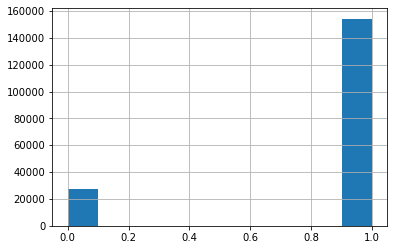

In [9]:
# Split target and feature
target   = applications_full['project_is_approved']
features = applications_full.drop(columns=['project_is_approved','id', 'project_submitted_datetime'])

print('Target: {}'.format(target.shape))
print('Features: {}'.format(features.shape))

# Plot histogram of target
target.hist()

## **Part 2**: Encode Categories

**Q 1:** What would be a possible issue with one-hot encoding of teacher_id column? Should we keep this feature? There might be another, more useful teacher-specific feature we can use. Which one?

In [10]:
features.drop(columns = ['teacher_id'], inplace = True)
features.shape

(182076, 11)

**Q 2:** Encode these categorical features using one-hot-encoding: ['teacher_prefix', 'school_state', 'project_grade_category']

In [11]:
cols_to_transform = ['teacher_prefix', 'school_state', 'project_grade_category']

features = pd.get_dummies(data = features, columns = cols_to_transform, drop_first=True)
features.shape

(182076, 65)

**Q 3:** What could be the issue with simply one-hot-encoding of *project_subject_category* and *project_subject_subcategory* features? Come up with a sensible approach and implement it.

In [12]:
# Let's start with the subject categories

# Extract only the categories column
features_categories = features[['project_subject_categories']].copy()
features_categories['project_subject_categories_list'] = features_categories['project_subject_categories'].str.split(', ')
features_categories.drop(columns=['project_subject_categories'], inplace=True)

# Explode the column
features_categories = features_categories.explode('project_subject_categories_list')
print('Number of categories: {}'.format(len(set(features_categories['project_subject_categories_list'].values))))
Counter(features_categories['project_subject_categories_list'].values)

Number of categories: 9


Counter({'Literacy & Language': 86984,
         'Music & The Arts': 17054,
         'Health & Sports': 23712,
         'Math & Science': 69246,
         'Applied Learning': 20303,
         'Special Needs': 22881,
         'History & Civics': 9726,
         'Warmth': 2327,
         'Care & Hunger': 2327})

In [13]:
# One-hot encode the applications now and group them by index values
features_categories = pd.get_dummies(features_categories, columns=['project_subject_categories_list'])
features_categories = features_categories.groupby(features_categories.index).sum()
features_categories.shape

(182076, 9)

In [14]:
# Now repeat the process for subject subcategories

# Extract only the categories column
features_subcategories = features[['project_subject_subcategories']].copy()
features_subcategories['project_subject_subcategories_list'] = features_subcategories['project_subject_subcategories'].str.split(', ')
features_subcategories.drop(columns=['project_subject_subcategories'], inplace=True)

# Explode the column
features_subcategories = features_subcategories.explode('project_subject_subcategories_list')
print('Number of sub-categories: {}'.format(len(set(features_subcategories['project_subject_subcategories_list'].values))))
Counter(features_subcategories['project_subject_subcategories_list'].values)


Number of sub-categories: 30


Counter({'Literacy': 56065,
         'Performing Arts': 3223,
         'Team Sports': 3643,
         'Applied Sciences': 17966,
         'Literature & Writing': 36971,
         'Health & Wellness': 17099,
         'Character Education': 3519,
         'Early Development': 7149,
         'Mathematics': 46882,
         'Special Needs': 22881,
         'ESL': 7162,
         'Health & Life Science': 7175,
         'College & Career Prep': 4291,
         'Environmental Science': 9436,
         'Other': 3948,
         'Social Sciences': 3149,
         'Music': 5172,
         'Visual Arts': 10399,
         'History & Geography': 5258,
         'Parent Involvement': 1103,
         'Extracurricular': 1332,
         'Gym & Fitness': 7592,
         'Warmth': 2327,
         'Care & Hunger': 2327,
         'Foreign Languages': 1496,
         'Nutrition Education': 2236,
         'Community Service': 712,
         'Financial Literacy': 956,
         'Civics & Government': 1294,
         'Economics':

In [15]:
# One-hot encode the applications now and group them by index values
features_subcategories = pd.get_dummies(features_subcategories, columns=['project_subject_subcategories_list'])
features_subcategories = features_subcategories.groupby(features_subcategories.index).sum()
features_subcategories.shape

(182076, 30)

In [16]:
# Merge one-hot encoded categories and sub-categories with the dataframe

# Categories
features = features.merge(features_categories, how='left', left_index=True, right_index=True)

# Sub-categories
features = features.merge(features_subcategories, how='left', left_index=True, right_index=True)

print(features.shape)
features.head()

(182076, 104)


,project_subject_categories,project_subject_subcategories,project_title,project_resource_summary,teacher_number_of_previously_posted_projects,project_essay_env,project_essay_proj,total_budget,teacher_prefix_Mr.,teacher_prefix_Mrs.,...,project_subject_subcategories_list_Music,project_subject_subcategories_list_Nutrition Education,project_subject_subcategories_list_Other,project_subject_subcategories_list_Parent Involvement,project_subject_subcategories_list_Performing Arts,project_subject_subcategories_list_Social Sciences,project_subject_subcategories_list_Special Needs,project_subject_subcategories_list_Team Sports,project_subject_subcategories_list_Visual Arts,project_subject_subcategories_list_Warmth
0,Literacy & Language,Literacy,Super Sight Word Centers,My students need 6 Ipod Nano's to create and d...,26,Most of my kindergarten students come from low...,I currently have a differentiated sight word c...,899.94,0,0,...,0,0,0,0,0,0,0,0,0,0
1,"Music & The Arts, Health & Sports","Performing Arts, Team Sports",Keep Calm and Dance On,My students need matching shirts to wear for d...,1,Our elementary school is a culturally rich sch...,We strive to provide our diverse population of...,400.00,0,1,...,0,0,0,0,1,0,0,1,0,0
2,"Math & Science, Literacy & Language","Applied Sciences, Literature & Writing",Lets 3Doodle to Learn,My students need the 3doodler. We are an SEM s...,5,Hello;\r\nMy name is Mrs. Brotherton. I teach ...,We are looking to add some 3Doodler to our cla...,469.99,0,0,...,0,0,0,0,0,0,0,0,0,0
3,Health & Sports,Health & Wellness,"\""Kid Inspired\"" Equipment to Increase Activit...",My students need balls and other activity equi...,16,My students are the greatest students but are ...,"The student's project which is totally \""kid-i...",684.47,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Health & Sports,Health & Wellness,We need clean water for our culinary arts class!,My students need a water filtration system for...,42,My students are athletes and students who are ...,For some reason in our kitchen the water comes...,711.00,1,0,...,0,0,0,0,0,0,0,0,0,0


In [17]:
# Drop the original columns
features.drop(columns=['project_subject_categories','project_subject_subcategories'], inplace=True)

features.shape

(182076, 102)

## **Part 3**: Encode Text

In this part, we use a new data science package called [TextHero](https://github.com/jbesomi/texthero) for easy text pre-processing.

In [18]:
# Concat all textual features
features['app_text'] = features['project_title'] + ' ' + features['project_essay_env'] + ' ' + features['project_essay_proj'] + ' ' + features['project_resource_summary']
features.drop(columns = ['project_title',
                         'project_resource_summary',
                         'project_essay_env',
                         'project_essay_proj'], inplace = True)


features['app_text_clean'] = features['app_text'].pipe(hero.clean)
features_pca = features['app_text_clean'].pipe(hero.tfidf, max_features=500).pipe(hero.pca, n_components=50)
textual_features_pca = pd.DataFrame(dict(zip(features_pca.index, features_pca.values))).T

**Q 4:** You can think of generating some new features out of text which are beneficial for the target application in mind. In particular, add the number of words in application text as a new feature.


In [19]:
# Generate 'number of words' feature
num_words = features['app_text'].str.split().str.len()

features['num_words'] = num_words

## **Part 4**: Prepare Features and Baseline

**Q 1:** Organize your features into three dataframes of *textual_features* (projected to 50 PCA dimensions), *non_textual_features* and *all_features*. Check the data types of all features: are they all numeric? 

In [20]:
# Textual features
textual_features_pca.columns = ['dim_' + str(col) for col in textual_features_pca.columns]
textual_features = textual_features_pca.copy()

# Only keep non-textual featues, i.e. drop 2 application text columns
non_textual_features = features.drop(columns=['app_text', 'app_text_clean'])

# All features: are all types numeric? 
all_features = pd.concat([non_textual_features, textual_features], axis = 1)
all_features.dtypes

teacher_number_of_previously_posted_projects                  int64
total_budget                                                float64
teacher_prefix_Mr.                                            uint8
teacher_prefix_Mrs.                                           uint8
teacher_prefix_Ms.                                            uint8
teacher_prefix_Teacher                                        uint8
school_state_AL                                               uint8
school_state_AR                                               uint8
school_state_AZ                                               uint8
school_state_CA                                               uint8
school_state_CO                                               uint8
school_state_CT                                               uint8
school_state_DC                                               uint8
school_state_DE                                               uint8
school_state_FL                                 

**Q 2:** Come up with a conceptual baseline to compare with your models. No coding required.

## **Part 5**: Gradient Boosting Trees

**Q 1:** Fit a gradient boosting tree model from the the *XGBoost* library to your data and tune the value of the *n_estimators* parameter, the number of trees to fit. Use nested cross-validation function with 3 splits each in the inner and outer folds. Assess the performance of your model when tuning the *n_estimators* parameter and using the following sets of features:

1. Non-textual features
2. Textual features
3. All features

Hint: Use the following function for nested cross-validation (Try to understand it before using it):

    from sklearn.model_selection import StratifiedKFold, GridSearchCV, cross_val_score

    def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = 1, seed = 0):

        # cross-validation schema for inner and outer loops
        inner_cv = StratifiedKFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
        outer_cv = StratifiedKFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)

        # grid search to tune hyper parameters
        est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)

        # nested CV with parameter optimization
        nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)

        print('Average score: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))
        
Moreover use the *XGBClassifier* class from *xgboost* package, which has a similar interface to other sklearn classifiers. *XGboost* library includes high perfromance implementations of gradient boosting trees. 

In [21]:
# Nested cross validation function

def nested_cv(X, y, est_pipe, p_grid, p_score, n_splits_inner = 3, n_splits_outer = 3, n_cores = 1, seed = SEED):

    # Cross-validation schema for inner and outer loops
    inner_cv = StratifiedKFold(n_splits = n_splits_inner, shuffle = True, random_state = seed)
    outer_cv = StratifiedKFold(n_splits = n_splits_outer, shuffle = True, random_state = seed)
    
    # Grid search to tune hyper parameters
    est = GridSearchCV(estimator = est_pipe, param_grid = p_grid, cv = inner_cv, scoring = p_score, n_jobs = n_cores)

    # Nested CV with parameter optimization
    nested_scores = cross_val_score(estimator = est, X = X, y = y, cv = outer_cv, scoring = p_score, n_jobs = n_cores)
    
    print('Average score: %0.4f (+/- %0.4f)' % (nested_scores.mean(), nested_scores.std() * 1.96))

# Define pipeline
estimators = []
estimators.append(('xgb_clf', XGBClassifier()))
xgb_pipe = Pipeline(estimators)
xgb_pipe.set_params(xgb_clf__n_jobs = -1)
xgb_pipe.set_params(xgb_clf__random_state = SEED)

# Setup possible values of parameters to optimize over
p_grid = {"xgb_clf__n_estimators": [int(i) for i in np.linspace(10, 100, 10)]}

In [22]:
%%time

# Non textual features
nested_cv(X = non_textual_features, y = target, est_pipe = xgb_pipe, p_grid = p_grid, p_score = SCORE, n_cores = -1)

Average score: 0.6131 (+/- 0.0083)
CPU times: user 66.1 ms, sys: 278 ms, total: 344 ms
Wall time: 6min 47s


In [23]:
%%time

# Textual features
nested_cv(X = textual_features_pca, y = target, est_pipe = xgb_pipe, p_grid = p_grid, p_score = SCORE, n_cores = -1)

Average score: 0.6657 (+/- 0.0048)
CPU times: user 62.9 ms, sys: 173 ms, total: 236 ms
Wall time: 11min 32s


In [24]:
%%time

# All features
nested_cv(X = all_features, y = target, est_pipe = xgb_pipe, p_grid = p_grid, p_score = SCORE, n_cores = -1)

Average score: 0.6902 (+/- 0.0067)
CPU times: user 79.6 ms, sys: 200 ms, total: 280 ms
Wall time: 17min 41s


**Q 2:** Print a list of the 10 most important features considering all features as pedictors. 

In [25]:
# Extract feature importances

xgb_clf = xgb_pipe.named_steps['xgb_clf']
xgb_clf.fit(all_features, target)

i = 0

for index in reversed(np.argsort(xgb_clf.feature_importances_)):
    
    print(all_features.columns[index].ljust(50) , ':', xgb_clf.feature_importances_[index])
    i = i + 1

    if (i == 10):
        break

[18:02:54] WARNING: ../src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
teacher_number_of_previously_posted_projects       : 0.033817135
project_subject_subcategories_list_Music           : 0.021392545
dim_2                                              : 0.021288274
dim_3                                              : 0.017761173
num_words                                          : 0.015833858
project_subject_categories_list_Literacy & Language : 0.015643999
dim_0                                              : 0.014114005
project_subject_categories_list_Care & Hunger      : 0.014018507
project_subject_subcategories_list_History & Geography : 0.013603547
dim_16                                             : 0.013293306


## **Bonus**: Further Reading

- Further ideas for feature engineering: https://www.kaggle.com/shivamb/extensive-text-data-feature-engineering
- Winning submission on Kaggle (don't worry if you don't understand everything): https://www.kaggle.com/shadowwarrior/1st-place-solution